In [1]:
source("./utils.R")

here() starts at /home/gridsan/tdn/replicate-papers/covid-infections/SARS-CoV-2-VL-paper

This is cmdstanr version 0.6.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/gridsan/tdn/.cmdstan/cmdstan-2.33.1

- CmdStan version: 2.33.1

This is posterior version 1.5.0


Attaching package: ‘posterior’


The following objects are masked from ‘package:stats’:

    mad, sd, var


The following objects are masked from ‘package:base’:

    %in%, match


This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘bayesplot’


The following object is masked from ‘package:posterior’:

    rhat



Attaching package: ‘EnvStats’


The following objects are masked from ‘package:stats’:

    predict, predict.lm


Loading required package: R.oo

Loading req

In [2]:
library(ggdist)
library(patchwork)


Attaching package: ‘ggdist’


The following object is masked from ‘package:R.oo’:

    ll




# Read fit from disk

In [3]:
B117fit <- readRDS("B117fits/B117fit.RData")

In [4]:
B117fit$fit %>% 
  as_draws() %>% 
  head()

# A draws_array: 6 iterations, 4 chains, and 265 variables
, , variable = b_Intercept

         chain
iteration   1   2   3   4
        1 6.1 6.0 6.3 6.3
        2 6.1 6.4 5.9 6.2
        3 6.2 6.3 6.3 6.2
        4 6.1 6.1 6.3 6.1
        5 6.0 6.3 5.8 6.2

, , variable = b_sigma_Intercept

         chain
iteration    1    2    3    4
        1 0.54 0.53 0.54 0.61
        2 0.55 0.59 0.56 0.58
        3 0.53 0.53 0.53 0.54
        4 0.57 0.56 0.55 0.60
        5 0.49 0.56 0.57 0.54

, , variable = b_B117B117

         chain
iteration    1    2    3    4
        1 1.03 1.12 1.05 1.14
        2 1.08 0.95 1.04 1.13
        3 0.99 1.13 0.94 0.93
        4 1.07 1.10 0.90 1.18
        5 1.04 1.13 1.11 0.96

, , variable = b_GroupPAMS

         chain
iteration     1    2    3    4
        1 0.188 0.14 0.37 0.22
        2 0.037 0.20 0.37 0.26
        3 0.259 0.29 0.24 0.40
        4 0.337 0.34 0.25 0.32
        5 0.334 0.21 0.39 0.58

# ... with 1 more iterations, and 261 more variables

# Create data frames

In [5]:
B117.draws = 
  as_draws(B117fit$fit) %>% 
  subset_draws(c("b_Intercept","b_B117B117")) %>% 
  as_draws_dt() %>% 
  setkeyv(".draw") %>% 
  .[, `:=` (
    load.nonB117 = b_Intercept,
    load.B117 = b_Intercept + b_B117B117)] %>% 
  .[, .(.draw, load.nonB117, load.B117)] %>% 
  .[, `:=`(load.deltaB117 = load.B117 - load.nonB117)] %>% 
  melt(id.vars = ".draw") %>% 
  .[, B117 := ifelse(grepl("RR",variable),"RRB117",
                     ifelse(grepl("delta",variable),"deltaB117",
                            ifelse(grepl("nonB117",variable),"nonB117","B117")))] %>% 
  .[, Outcome := "log10Load"]

In [6]:
B117.draws %>% head()

.draw,variable,value,B117,Outcome
<int>,<fct>,<dbl>,<chr>,<chr>
1,load.nonB117,6.08805,nonB117,log10Load
2,load.nonB117,6.14040,nonB117,log10Load
3,load.nonB117,6.21170,nonB117,log10Load
4,load.nonB117,6.11054,nonB117,log10Load
5,load.nonB117,5.97482,nonB117,log10Load
6,load.nonB117,6.14872,nonB117,log10Load


# Plot

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


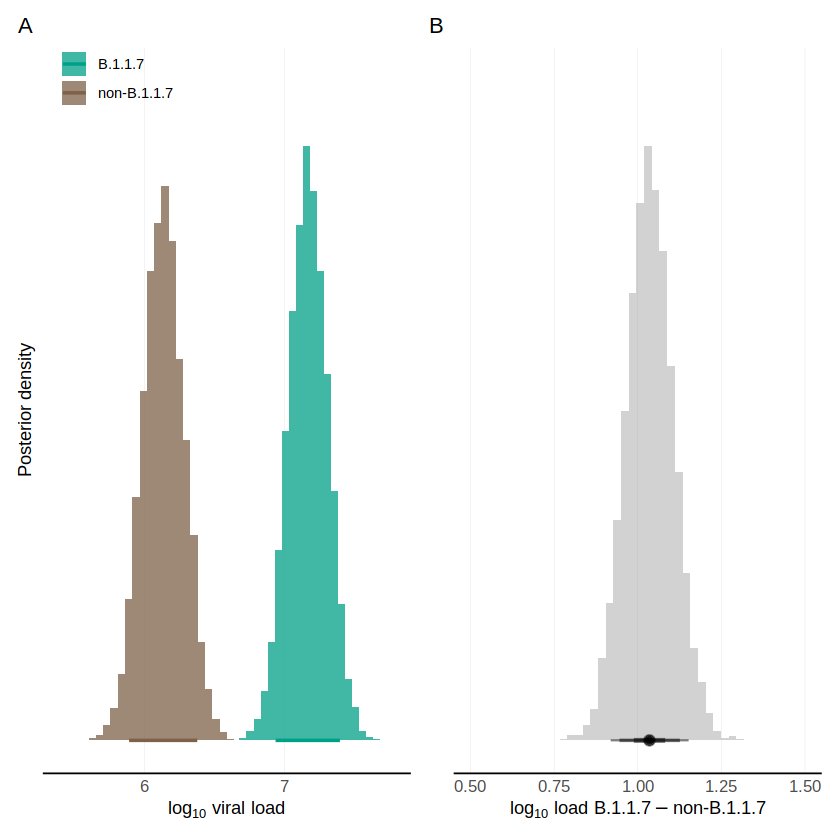

In [7]:
no_y_axis = theme(axis.title.y = element_blank(), axis.line.y = element_blank(), axis.text.y = element_blank())

p1 = 
  B117.draws[Outcome == "log10Load" & !(grepl("delta|RR",B117))] %>% 
  ggplot(aes(x = value, fill = B117)) +
  stat_histinterval(.width = c(.50, .80, .90), breaks = 25, alpha = .75, color = NA) + 
  scale_fill_manual(values = c("#00A087FF","#7E6148FF"),
                    name = "", labels = c("B.1.1.7","non-B.1.1.7")) +
  scale_color_manual(values = c("#00A087FF","#7E6148FF"),
                    name = "", labels = c("B.1.1.7","non-B.1.1.7")) +
  theme(axis.line.y = element_blank(), axis.text.y = element_blank()) +
  xlab(expression(log[10]~viral~load)) + 
  theme(legend.position = c(.2,.975)) + 
  ylab("Posterior density")

hdi.data = rbind(
  B117.draws[variable == "load.B117",value] %>% 
  fast.hdi(posterior.dist = "norm") %>% 
  .[,.(lower90,upper90)] %>% 
  .[, hdi.group := 1] %>% 
  melt(id.vars = "hdi.group") %>% 
  .[, B117 := "B117"] %>% 
  .[, y := 0],
  B117.draws[variable == "load.nonB117",value] %>% 
  fast.hdi(posterior.dist = "norm") %>% 
  .[,.(lower90,upper90)] %>% 
  .[, hdi.group := 1] %>% 
  melt(id.vars = "hdi.group") %>% 
  .[, B117 := "nonB117"] %>% 
  .[, y := 0])

p1 = 
  p1 +
  geom_line(data = hdi.data,
            aes(y = y, x = value, group = interaction(hdi.group,B117), color = B117),
            size = 1) + 
  gg_add_grid("x")

p2 = 
  B117.draws[Outcome == "log10Load" & (grepl("delta",B117))] %>% 
  ggplot(aes(x = value)) +
  stat_histinterval(.width = c(.50, .80, .90), breaks = 25, alpha = .5) + 
  theme(axis.line.y = element_blank(), axis.text.y = element_blank()) +
  xlab(expression(log[10]~load~B.1.1.7-`non-B.1.1.7`)) +
  coord_cartesian(xlim= c(0.5,1.5)) +
  ylab("") + 
  gg_add_grid("x")

pB117load = (p1 + ggtitle("A")| p2 + ggtitle("B")) + plot_layout(widths = c(1,1))


pB117load